In [1]:
import h5py
import numpy as np
import pandas as pd
import scipy
from scipy import signal
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

2023-02-27 20:50:37.928509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def getData(cfileName):

    # Read the *.cfile which has each element in float32 format.
    data = np.fromfile(cfileName, dtype="float32")

    # Take each consecutive interleaved I sample and Q sample to create a single complex element.
    data = data[0::2] + 1j*data[1::2]
    #print("data type=", type(data))
    # Return the complex numpy array.
    return data


def create_dataset(data, class_label):
    f, t, Zxx = signal.stft(data, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
    print(len(f))
    print(len(t))
    print(Zxx.shape)

    del data

    Zxx = Zxx.transpose()

    Zxx = abs(Zxx)
    # scaling the features (only real part of the data can be used)
    scaler = MinMaxScaler()
    scaler.fit(Zxx)
    print(scaler.data_max_)
    Zxx = scaler.transform(Zxx)

    X = Zxx[:num_samp_per_class]
    Y = np.full(num_samp_per_class, class_label)

    return X, Y


# number of samples per class
num_samp_per_class = 10000

# FFT size for the STFT operation (which is same as the feature vector size)
fft_size = feature_vector_size = 2048 #1024

# number of overlapping samples for the STFT operation
fft_overlap = 256

## iPhone14Pro_I(v) dataset

In [3]:
class_label = 10
for i in range(class_label):

    folder_path = "/Volumes/Transcend/PhD in Computing/Data Collection/Smartphones/EM_Signals_iPhone14Pro_I_Validate/iPhone14Pro_I(v)/"
    if(i==0):
        data = getData(folder_path + "calendar-app.cfile")
        print(np.array(data))
        X, Y = create_dataset(data, i)

    else:

        if(i==1):
            data = getData(folder_path + "camera-photo.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==2):
            data = getData(folder_path + "camera-video.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==3):
            data = getData(folder_path + "email-app.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==4):
            data = getData(folder_path + "gallery-app.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==5):
            data = getData(folder_path + "home-screen.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==6):
            data = getData(folder_path + "idle.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==7):
            data = getData(folder_path + "phone-app.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==8):
            data = getData(folder_path + "sms-app.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==9):
            data = getData(folder_path + "web_browser-app.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        X = np.concatenate((X, dataset), axis=0) 
        Y = np.concatenate((Y, label), axis=0)
        
    print(i)
    print(X.shape)
    print(Y.shape)

# combine all em signals into one dataframe
em_data = pd.DataFrame(X)
em_data.insert(len(em_data.columns), 'labels', Y)

# save to csv file
# (em_data.T).to_csv(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone13/i13_I_BeSh.csv', header=False)

[0.0078125+0.015625j  0.015625 +0.0078125j 0.015625 -0.0078125j ...
 0.0234375+0.0078125j 0.03125  +0.0078125j 0.015625 +0.0078125j]
2048
81192
(2048, 81192)
[0.01867803 0.00976685 0.00376288 ... 0.00200002 0.00394439 0.00999402]
0
(10000, 2048)
(10000,)
[0.       +0.0078125j 0.0234375+0.j        0.03125  +0.j        ...
 0.0234375+0.j        0.0234375+0.0234375j 0.0078125+0.j       ]
2048
91139
(2048, 91139)
[0.01848593 0.00978156 0.00328117 ... 0.00211466 0.00385599 0.00974472]
1
(20000, 2048)
(20000,)
[-0.0078125+0.015625j   0.0234375+0.j         0.03125  +0.j        ...
  0.015625 +0.0078125j  0.015625 +0.0078125j  0.015625 -0.0078125j]
2048
88359
(2048, 88359)
[0.01869777 0.00970068 0.00339714 ... 0.00201213 0.00373061 0.00970339]
2
(30000, 2048)
(30000,)
[0.015625 +0.0078125j 0.015625 +0.0234375j 0.015625 +0.015625j  ...
 0.015625 -0.0078125j 0.015625 +0.015625j  0.0234375+0.0078125j]
2048
90187
(2048, 90187)
[0.01943404 0.01073077 0.0038433  ... 0.00181564 0.0036553  0.01024228]

## Cross-model Validation

## iPhone14Pro_I(i) model

Cross-model Validation without training

In [4]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone14Pro/iPhone14Pro_Own_Models/iPHONE14Pro_I(i)_model.h5")
model.summary()

2023-02-27 21:12:02.312885: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 4,511,210
Trainable params: 4,511,210
Non-

In [5]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

3125/3125 [==============================] - 13s 4ms/step - loss: 5.1960 - accuracy: 0.0873
test loss, test acc: [5.196002006530762, 0.08727999776601791]


In [6]:
y_pred = np.argmax(model.predict(X), axis=-1)


print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

3125/3125 [==============================] - 12s 4ms/step
[[   6  642  395    2 3430    3 1354 1030 2815  323]
 [   0 4039    4    0  288  270 1592    2 3487  318]
 [   1 4800   27    0 1606   46 1860   89 1307  264]
 [   0 4804    0    0 1241  722  200    5 2153  875]
 [   0 2490    2    1  271  279 1868   71 4298  720]
 [   1 4039   90    0  316    5 2975   40 2365  169]
 [   0 1882   97    1 2391   14 1334  134 3477  670]
 [   1 1613 1610    0 1522    0 1656  996 2098  504]
 [   0 3755  117    0 2769    4 1066  154 1936  199]
 [   1 3347   13    0    4   21 2030    2 4468  114]]
              precision    recall  f1-score   support

           0       0.60      0.00      0.00     10000
           1       0.13      0.40      0.20     10000
           2       0.01      0.00      0.00     10000
           3       0.00      0.00      0.00     10000
           4       0.02      0.03      0.02     10000
           5       0.00      0.00      0.00     10000
           6       0.08      0.1

Test Accuracy:0.08728


Text(0.5, 1.0, 'Accuracy:0.087')

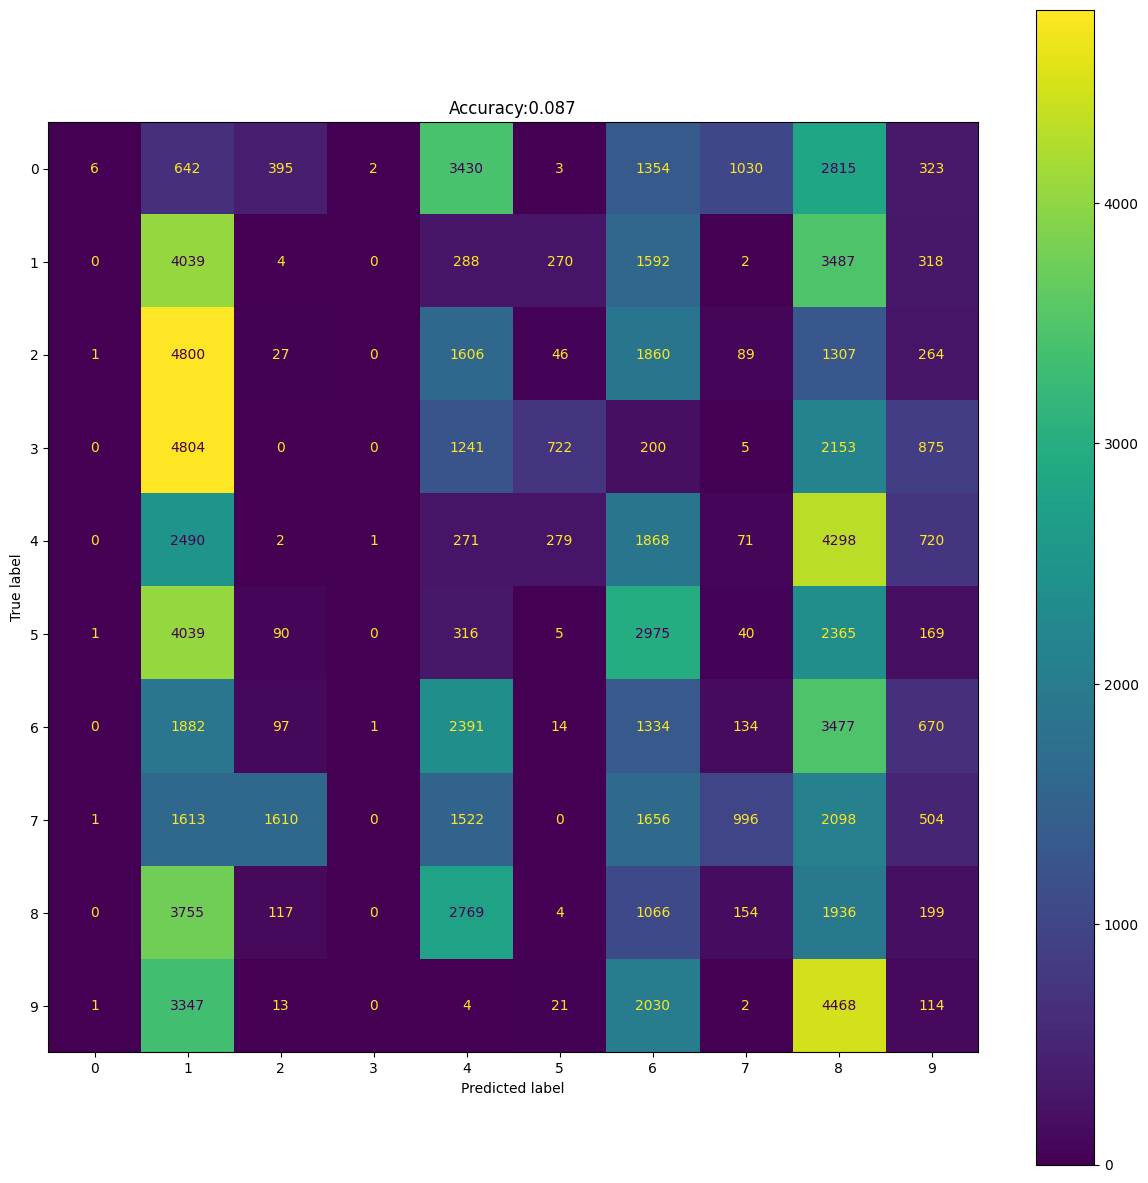

In [7]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone13/iPhone13_II_confusion_matrix.pdf')

Cross-model Validation by applying Transfer Learning

In [8]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 4,511,210
Trainable params: 1,010
Non-trai

In [10]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
3125/3125 [==============================] - 13s 4ms/step - loss: 1.2224 - accuracy: 0.5754
Epoch 2/30
3125/3125 [==============================] - 12s 4ms/step - loss: 1.2184 - accuracy: 0.5765
Epoch 3/30
3125/3125 [==============================] - 11s 4ms/step - loss: 1.2142 - accuracy: 0.5788
Epoch 4/30
3125/3125 [==============================] - 11s 4ms/step - loss: 1.2102 - accuracy: 0.5799
Epoch 5/30
3125/3125 [==============================] - 11s 4ms/step - loss: 1.2063 - accuracy: 0.5813
Epoch 6/30
3125/3125 [==============================] - 12s 4ms/step - loss: 1.2025 - accuracy: 0.5835
Epoch 7/30
3125/3125 [==============================] - 12s 4ms/step - loss: 1.1987 - accuracy: 0.5851
Epoch 8/30
3125/3125 [==============================] - 11s 4ms/step - loss: 1.1949 - accuracy: 0.5870
Epoch 9/30
3125/3125 [==============================] - 11s 4ms/step - loss: 1.1913 - accuracy: 0.5887
Epoch 10/30
3125/3125 [==============================] - 11s 4ms/step - l

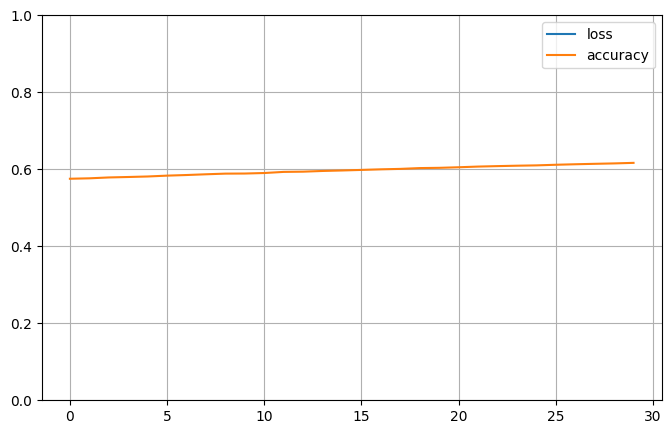

In [11]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [12]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

3125/3125 [==============================] - 12s 4ms/step - loss: 1.1247 - accuracy: 0.6161
test loss, test acc: [1.1246715784072876, 0.6160899996757507]


In [13]:
y_pred = np.argmax(model.predict(X), axis=-1)


print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

3125/3125 [==============================] - 11s 4ms/step
[[5552   28  163   43  226  221 1244 1804  719    0]
 [  33 5050 1034 1058 1622  415  478   14  112  184]
 [ 214 1007 4137  715  744  905  961  133 1144   40]
 [  23  687  507 7798  481   13  261   14  181   35]
 [ 168 1281  534  558 5979  549  634   83  136   78]
 [ 205  330  467   79  625 6949  517  115  481  232]
 [1077  343  778  370  745  610 4428  481 1161    7]
 [1186    7   64   19  127  131  425 7541  500    0]
 [ 740  164 1080  342  312  811 1503  656 4387    5]
 [   3    0    2    3   51   85    2   66    0 9788]]
              precision    recall  f1-score   support

           0       0.60      0.56      0.58     10000
           1       0.57      0.51      0.53     10000
           2       0.47      0.41      0.44     10000
           3       0.71      0.78      0.74     10000
           4       0.55      0.60      0.57     10000
           5       0.65      0.69      0.67     10000
           6       0.42      0.4

Test Accuracy:0.61609


Text(0.5, 1.0, 'Accuracy:0.616')

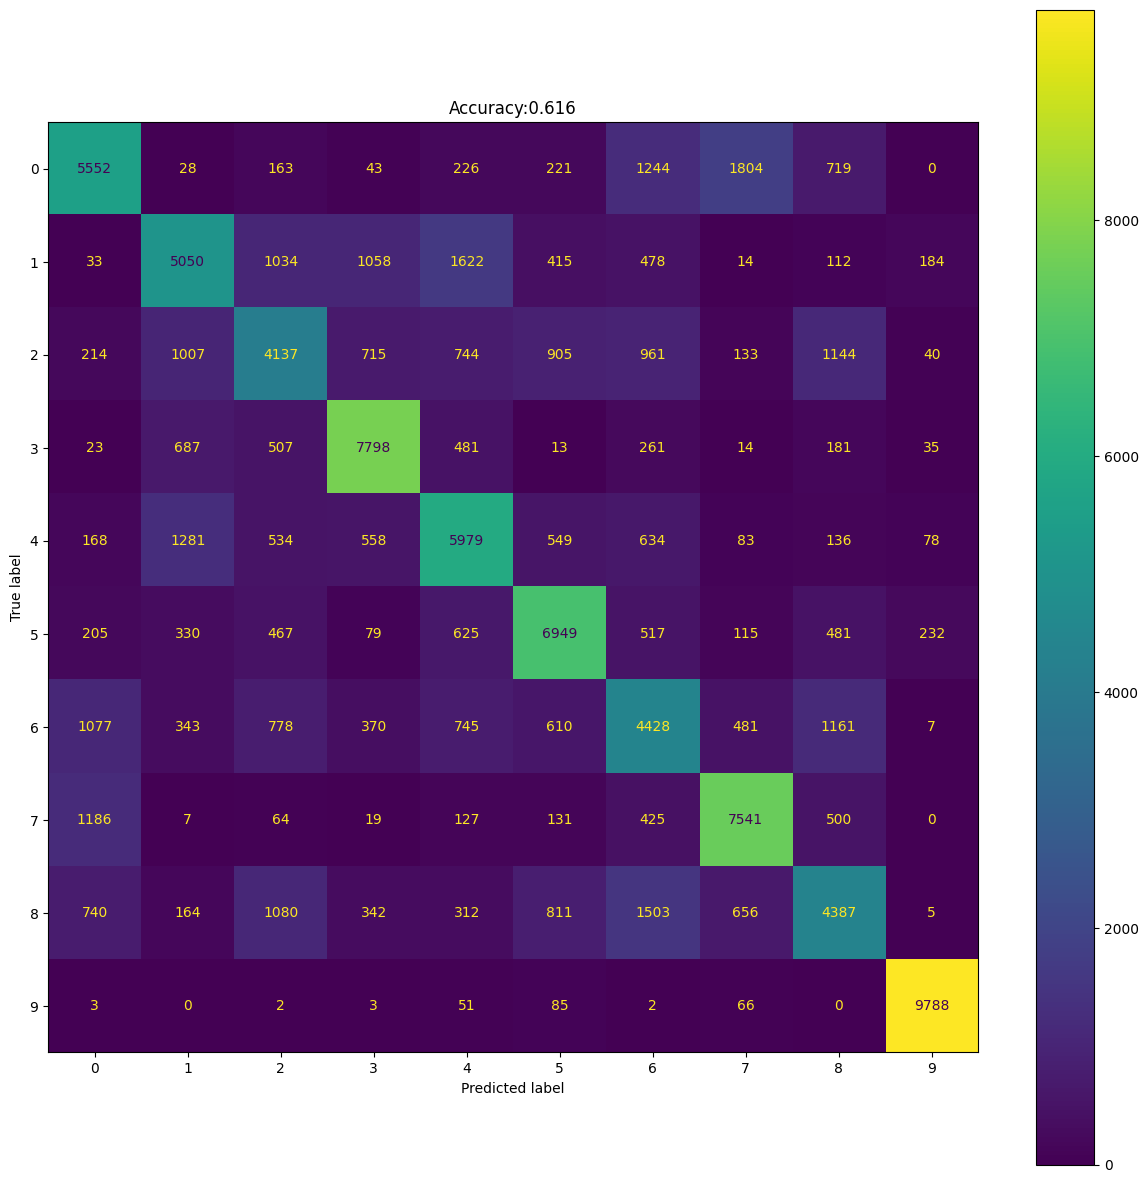

In [14]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone13/iPhone13_II_confusion_matrix.pdf')

## iPhone14Pro_I(ii) model

Cross-model Validation without training

In [15]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone14Pro/iPhone14Pro_Own_Models/iPHONE14Pro_I(ii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 10)                1010      
                                                                 
Total params: 4,511,210
Trainable params: 4,511,210
No

In [16]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

3125/3125 [==============================] - 13s 4ms/step - loss: 6.4466 - accuracy: 0.0836
test loss, test acc: [6.446623802185059, 0.08363000303506851]


In [17]:
y_pred = np.argmax(model.predict(X), axis=-1)


print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

3125/3125 [==============================] - 12s 4ms/step
[[   2 1851  267    1 6219 1464  183   11    2    0]
 [   0   26  133    1 5820 3995   25    0    0    0]
 [   0  150  259    0 4777 4806    6    0    2    0]
 [   0   11   11    1 1866 8110    0    0    0    1]
 [   0   53  197    0 4534 5206    8    0    1    1]
 [   0  240  372    0 5844 3471   71    1    0    1]
 [   1  577  358    0 6936 2078   46    3    1    0]
 [   3 2622  282    0 5645 1314   91   17   25    1]
 [   1  805  636    0 6640 1894   22    0    2    0]
 [   0    7    2    4 2286 7693    2    1    0    5]]
              precision    recall  f1-score   support

           0       0.29      0.00      0.00     10000
           1       0.00      0.00      0.00     10000
           2       0.10      0.03      0.04     10000
           3       0.14      0.00      0.00     10000
           4       0.09      0.45      0.15     10000
           5       0.09      0.35      0.14     10000
           6       0.10      0.0

Test Accuracy:0.08363


Text(0.5, 1.0, 'Accuracy:0.084')

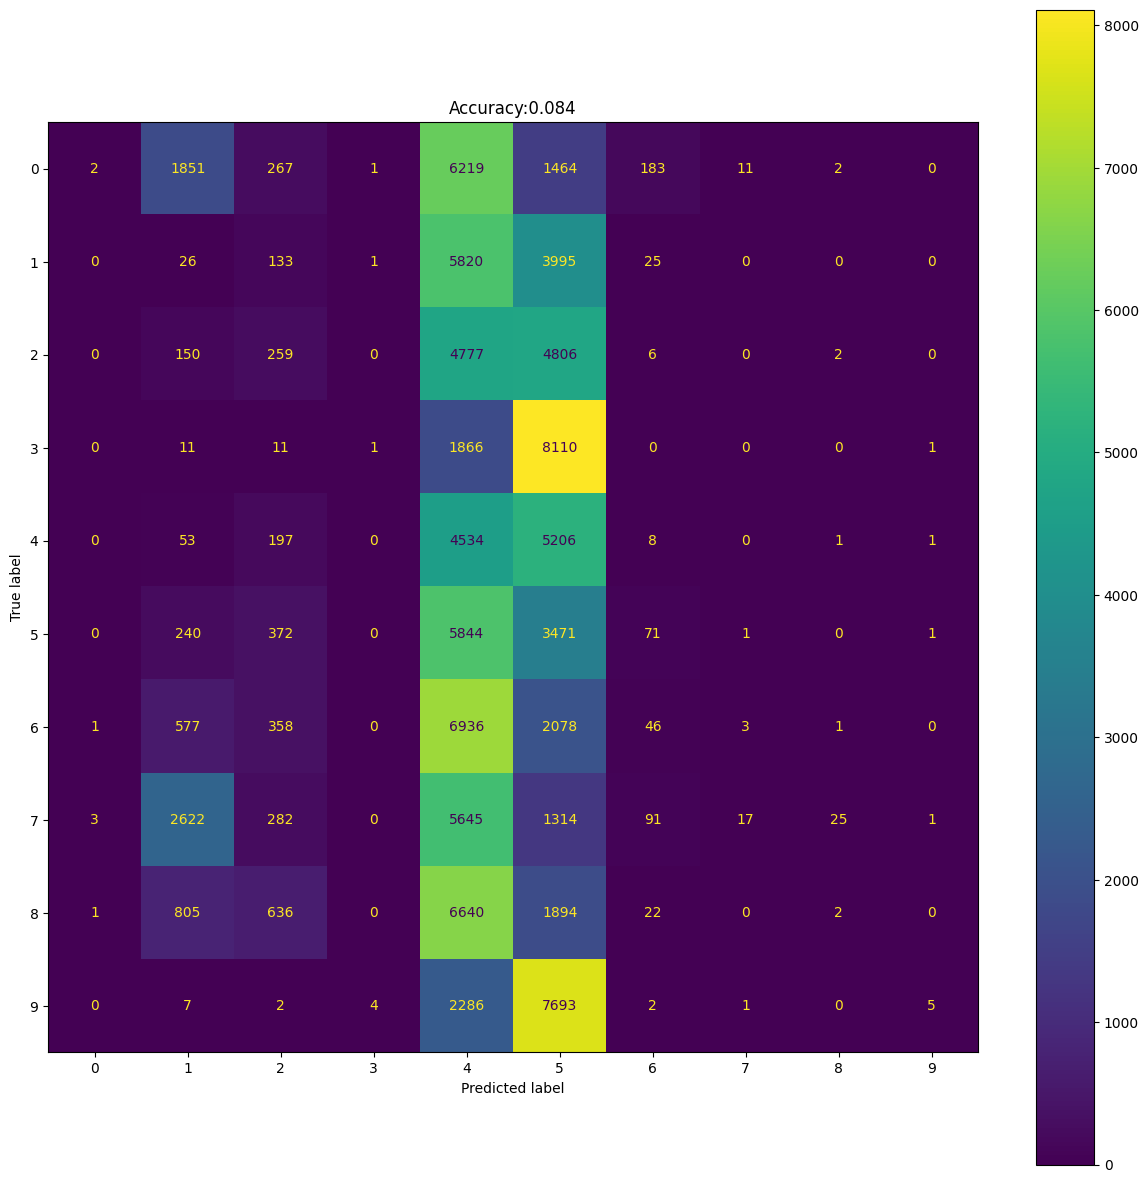

In [18]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone13/iPhone13_II_confusion_matrix.pdf')

Cross-model Validation by applying Transfer Learning

In [19]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 10)                1010      
                                                                 
Total params: 4,511,210
Trainable params: 1,010
Non-tr

In [20]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
3125/3125 [==============================] - 12s 4ms/step - loss: 2.5677 - accuracy: 0.2223
Epoch 2/30
3125/3125 [==============================] - 12s 4ms/step - loss: 1.8841 - accuracy: 0.3296
Epoch 3/30
3125/3125 [==============================] - 12s 4ms/step - loss: 1.6218 - accuracy: 0.4106
Epoch 4/30
3125/3125 [==============================] - 12s 4ms/step - loss: 1.4796 - accuracy: 0.4645
Epoch 5/30
3125/3125 [==============================] - 12s 4ms/step - loss: 1.3923 - accuracy: 0.5044
Epoch 6/30
3125/3125 [==============================] - 12s 4ms/step - loss: 1.3341 - accuracy: 0.5302
Epoch 7/30
3125/3125 [==============================] - 12s 4ms/step - loss: 1.2917 - accuracy: 0.5490
Epoch 8/30
3125/3125 [==============================] - 13s 4ms/step - loss: 1.2595 - accuracy: 0.5616
Epoch 9/30
3125/3125 [==============================] - 11s 4ms/step - loss: 1.2339 - accuracy: 0.5709
Epoch 10/30
3125/3125 [==============================] - 11s 4ms/step - l

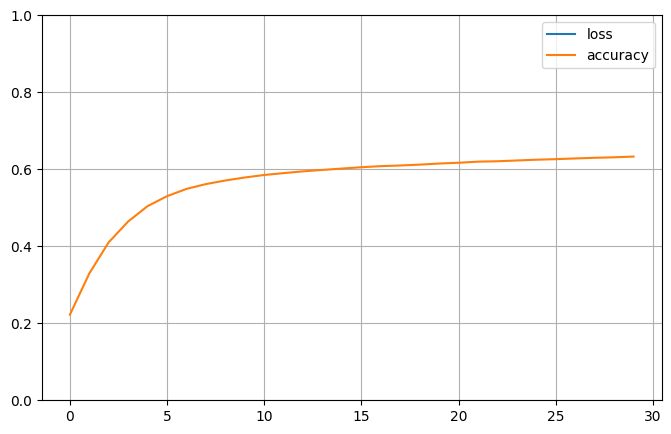

In [21]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [22]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

3125/3125 [==============================] - 12s 4ms/step - loss: 1.0410 - accuracy: 0.6336
test loss, test acc: [1.0410395860671997, 0.6335899829864502]


In [23]:
y_pred = np.argmax(model.predict(X), axis=-1)


print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

3125/3125 [==============================] - 12s 4ms/step
[[5866  134  321    3   57  493  980 1659  487    0]
 [ 120 5617  800  158 1817  536  257   46  419  230]
 [ 248  853 5158  460 1203  191  496  306 1051   34]
 [   2   34  241 9510   29    0    4    5   97   78]
 [  93 2195 1462  288 4370  525  314  111  484  158]
 [ 276  339   77    0  255 8978   24   28   22    1]
 [1570  400 1067   25  441  418 2951 1584 1542    2]
 [1410   45  252    4   66   81  756 6497  889    0]
 [ 571  503 1405   89  467   98 1000 1361 4502    4]
 [   0   35    0   20    5    2    0   25    3 9910]]
              precision    recall  f1-score   support

           0       0.58      0.59      0.58     10000
           1       0.55      0.56      0.56     10000
           2       0.48      0.52      0.50     10000
           3       0.90      0.95      0.93     10000
           4       0.50      0.44      0.47     10000
           5       0.79      0.90      0.84     10000
           6       0.44      0.3

Test Accuracy:0.63359


Text(0.5, 1.0, 'Accuracy:0.634')

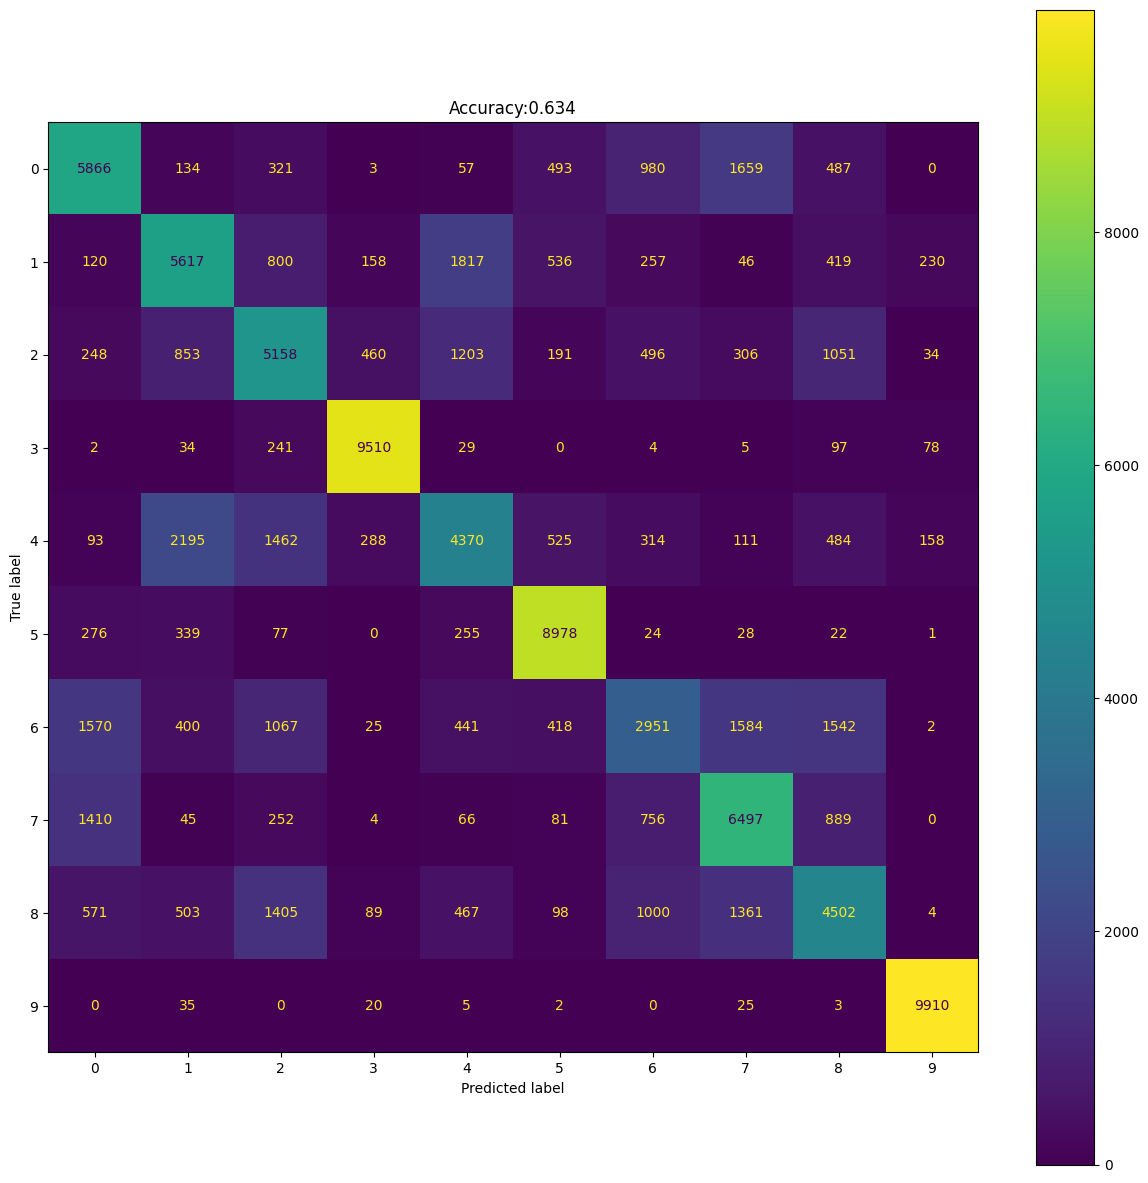

In [24]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone13/iPhone13_II_confusion_matrix.pdf')

## iPhone14Pro_I(iii) model

Cross-model Validation without training

In [25]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone14Pro/iPhone14Pro_Own_Models/iPHONE14Pro_I(iii)_model.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 10)                1010      
                                                                 
Total params: 4,511,210
Trainable params: 4,511,210
No

In [26]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

3125/3125 [==============================] - 14s 4ms/step - loss: 4.0190 - accuracy: 0.0962
test loss, test acc: [4.018981456756592, 0.09624999761581421]


In [27]:
y_pred = np.argmax(model.predict(X), axis=-1)


print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

3125/3125 [==============================] - 12s 4ms/step
[[ 426 3242  637  608   87  220  826 1421  354 2179]
 [ 744 1064  708  194   93   45  629 2552  584 3387]
 [ 154 2361  376   71  124   71  772 3592  123 2356]
 [ 475  607  203   54  420   97 1266 3354  720 2804]
 [ 379 2277  652   93   73   39  808 2684  286 2709]
 [ 349 5136   78  593   23  133  164 2000   84 1440]
 [ 452 2897  984  316  110  192 1368 1562  650 1469]
 [ 802 3165  585  341  193  398  376 1344  848 1948]
 [ 484 2524  831  157  213  431 1239 2108  685 1328]
 [1020  324   58 1024   11   19 2131 1311    0 4102]]
              precision    recall  f1-score   support

           0       0.08      0.04      0.06     10000
           1       0.05      0.11      0.06     10000
           2       0.07      0.04      0.05     10000
           3       0.02      0.01      0.01     10000
           4       0.05      0.01      0.01     10000
           5       0.08      0.01      0.02     10000
           6       0.14      0.1

Test Accuracy:0.09625


Text(0.5, 1.0, 'Accuracy:0.096')

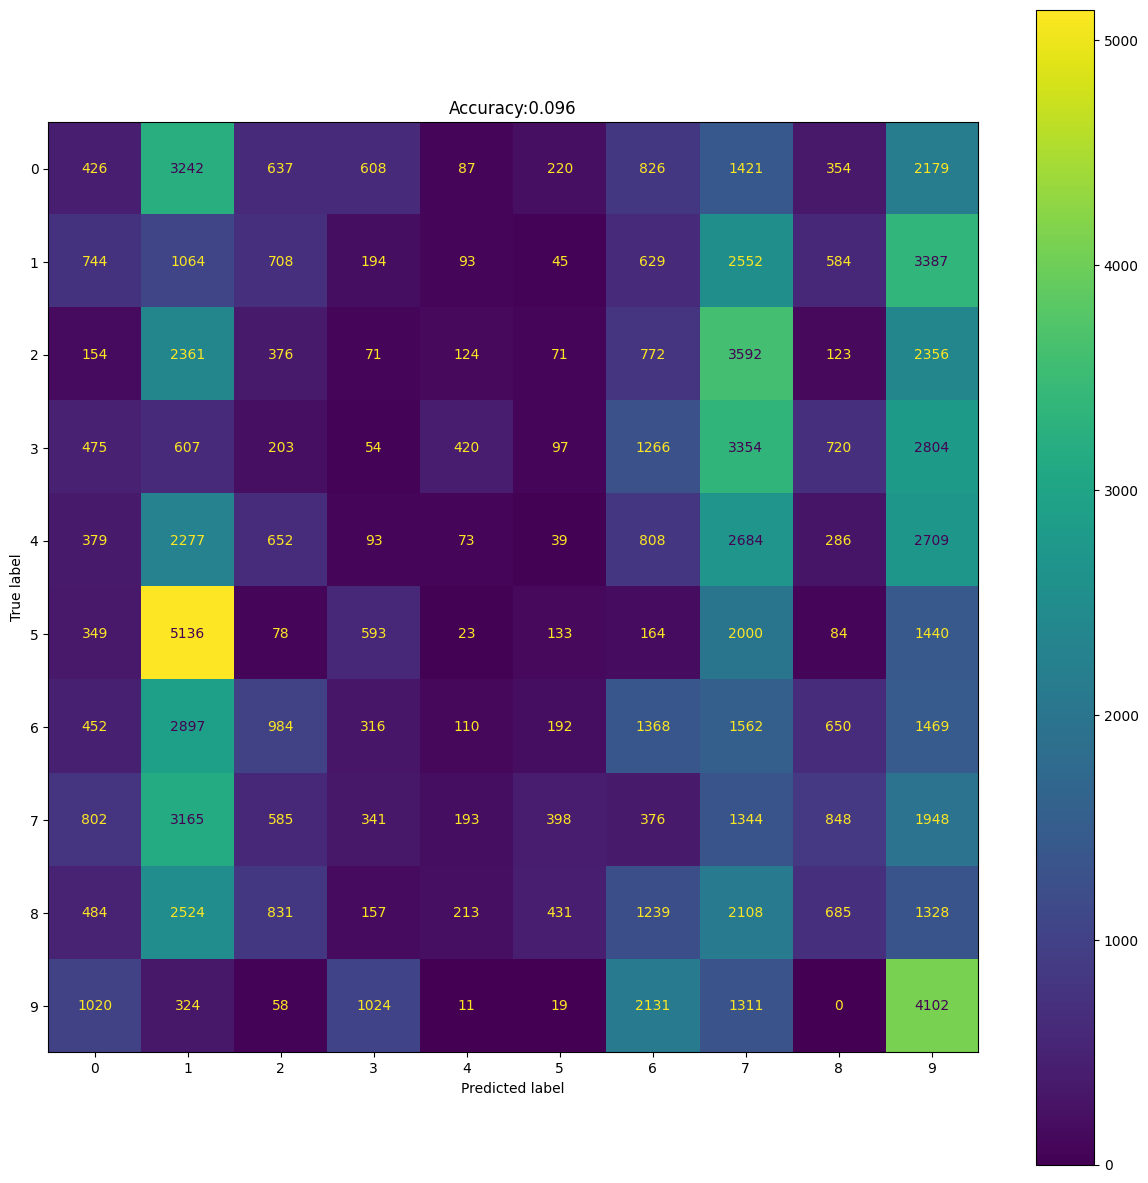

In [28]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone13/iPhone13_II_confusion_matrix.pdf')

Cross-model Validation by applying Transfer Learning

In [29]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 10)                1010      
                                                                 
Total params: 4,511,210
Trainable params: 1,010
Non-tr

In [30]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
3125/3125 [==============================] - 14s 4ms/step - loss: 3.1581 - accuracy: 0.1124
Epoch 2/30
3125/3125 [==============================] - 14s 4ms/step - loss: 2.4899 - accuracy: 0.1750
Epoch 3/30
3125/3125 [==============================] - 13s 4ms/step - loss: 2.1229 - accuracy: 0.2462
Epoch 4/30
3125/3125 [==============================] - 13s 4ms/step - loss: 1.9284 - accuracy: 0.3108
Epoch 5/30
3125/3125 [==============================] - 13s 4ms/step - loss: 1.8206 - accuracy: 0.3547
Epoch 6/30
3125/3125 [==============================] - 12s 4ms/step - loss: 1.7560 - accuracy: 0.3818
Epoch 7/30
3125/3125 [==============================] - 12s 4ms/step - loss: 1.7143 - accuracy: 0.3997
Epoch 8/30
3125/3125 [==============================] - 12s 4ms/step - loss: 1.6850 - accuracy: 0.4107
Epoch 9/30
3125/3125 [==============================] - 12s 4ms/step - loss: 1.6630 - accuracy: 0.4193
Epoch 10/30
3125/3125 [==============================] - 12s 4ms/step - l

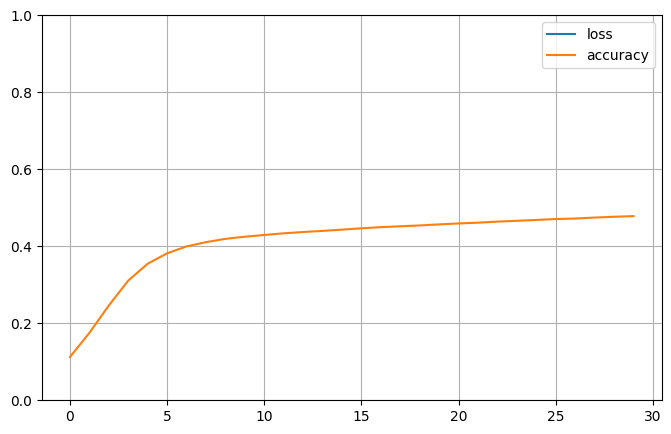

In [31]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [32]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

3125/3125 [==============================] - 12s 4ms/step - loss: 1.4964 - accuracy: 0.4801
test loss, test acc: [1.4964091777801514, 0.48014000058174133]


In [33]:
y_pred = np.argmax(model.predict(X), axis=-1)

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

3125/3125 [==============================] - 11s 4ms/step
[[3664  602  711  199  433 1313 1011 1144  640  283]
 [ 713 3963  702 1289 1022  434  480  535  606  256]
 [ 788  714 3929  935  945  678  543  470  841  157]
 [ 121  735  621 6855  284   88  135  493  622   46]
 [ 830 1454 1600  837 2542  642  706  472  704  213]
 [1051  220  427   63  271 6873  224  408  111  352]
 [1970  732  857  354  647  471 2558  979 1301  131]
 [1193  426  404  554  203  577  476 5155  954   58]
 [1025  628 1025  890  459  307 1070 1576 2974   46]
 [  28   64   34   17   22  294   25   12    3 9501]]
              precision    recall  f1-score   support

           0       0.32      0.37      0.34     10000
           1       0.42      0.40      0.41     10000
           2       0.38      0.39      0.39     10000
           3       0.57      0.69      0.62     10000
           4       0.37      0.25      0.30     10000
           5       0.59      0.69      0.63     10000
           6       0.35      0.2

Test Accuracy:0.48014


Text(0.5, 1.0, 'Accuracy:0.480')

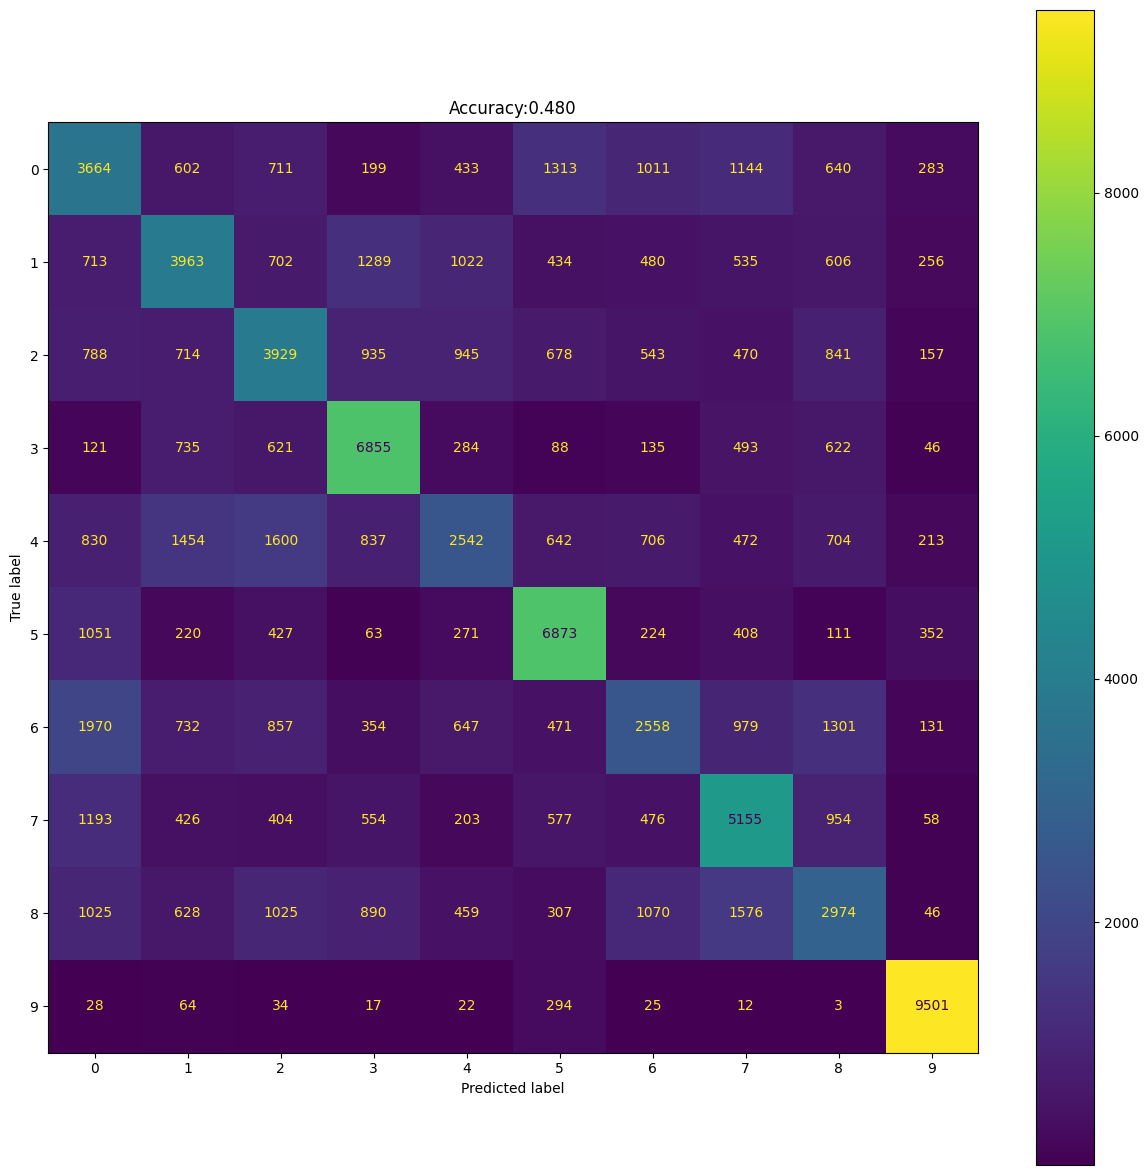

In [34]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone13/iPhone13_II_confusion_matrix.pdf')

## iPhone14Pro_I(iv) model

Cross-model Validation without training

In [35]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone14Pro/iPhone14Pro_Own_Models/iPHONE14Pro_I(iv)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 4,511,210
Trainable params: 4,511,210
Non-

In [36]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

3125/3125 [==============================] - 14s 4ms/step - loss: 6.5675 - accuracy: 0.1036
test loss, test acc: [6.567507266998291, 0.10356999933719635]


In [37]:
y_pred = np.argmax(model.predict(X), axis=-1)

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

3125/3125 [==============================] - 12s 4ms/step
[[1907 1120   22    2   34   36  373 5910   10  586]
 [2939 2890    0    0    0    8  110 4015    0   38]
 [2193 1436    1    0    5   18  244 5903    0  200]
 [1850 3007    2    0    1    0   46 5086    3    5]
 [3401 2662    5    0    1    6  181 3631    2  111]
 [1767 4194    0    0    5    0   14 3929    0   91]
 [2300 2248   14    0   32   14  197 4847    5  343]
 [1261 1869   40    5   40   51  280 5353    7 1094]
 [2050 1441    4    0   12   16  190 5851    0  436]
 [5516 2323    1    1    0    0   11 2139    1    8]]
              precision    recall  f1-score   support

           0       0.08      0.19      0.11     10000
           1       0.12      0.29      0.17     10000
           2       0.01      0.00      0.00     10000
           3       0.00      0.00      0.00     10000
           4       0.01      0.00      0.00     10000
           5       0.00      0.00      0.00     10000
           6       0.12      0.0

Test Accuracy:0.10357


Text(0.5, 1.0, 'Accuracy:0.104')

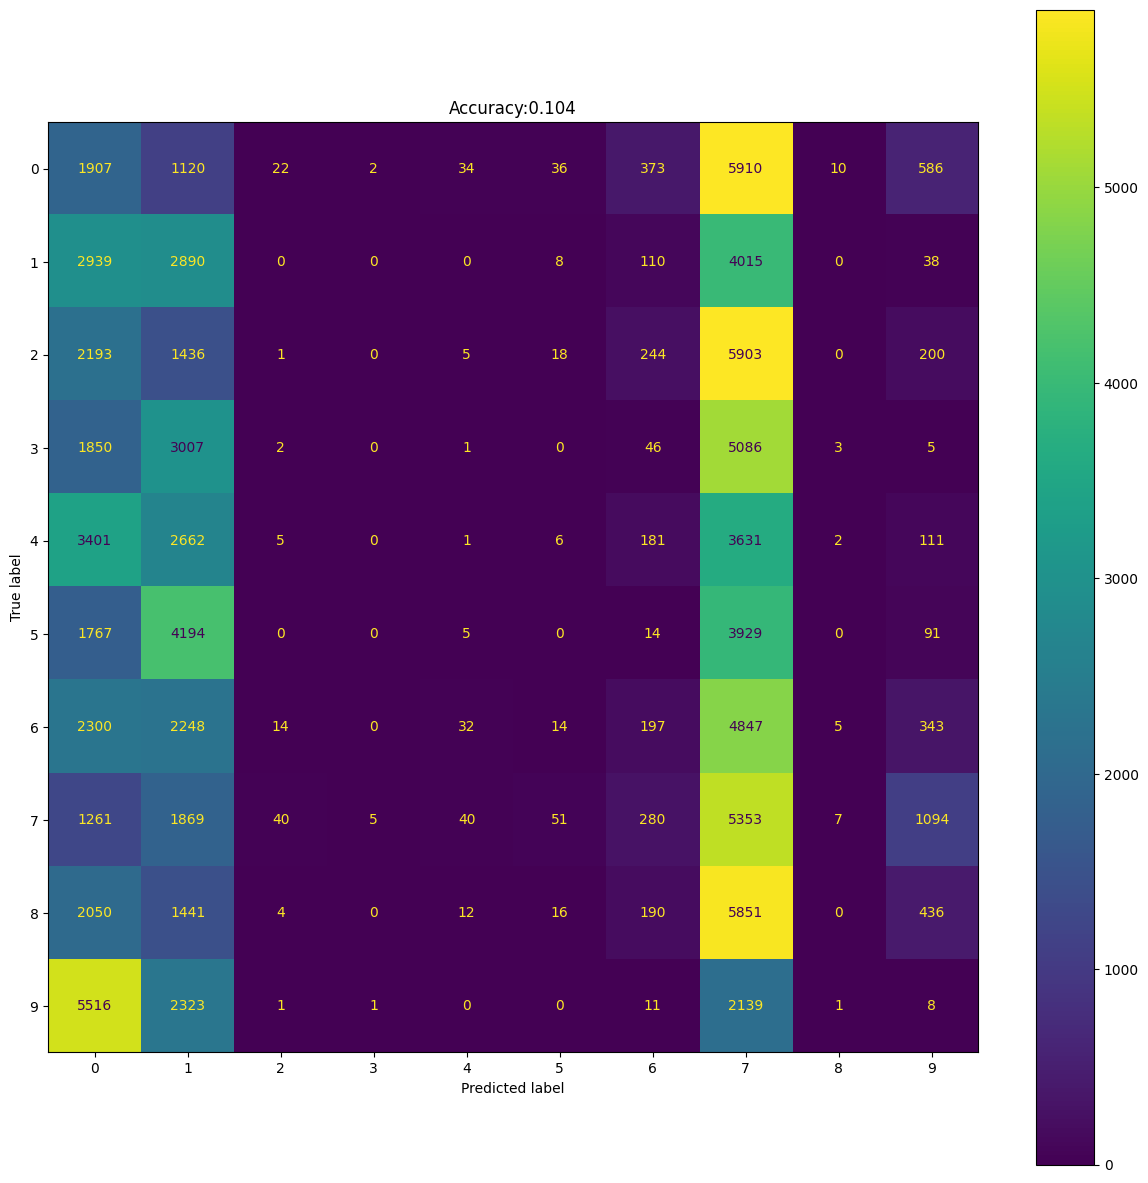

In [38]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone13/iPhone13_II_confusion_matrix.pdf')

Cross-model Validation by applying Transfer Learning

In [39]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 4,511,210
Trainable params: 1,010
Non-trai

In [40]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
3125/3125 [==============================] - 13s 4ms/step - loss: 3.2497 - accuracy: 0.0960
Epoch 2/30
3125/3125 [==============================] - 12s 4ms/step - loss: 2.3194 - accuracy: 0.1943
Epoch 3/30
3125/3125 [==============================] - 12s 4ms/step - loss: 1.9796 - accuracy: 0.2816
Epoch 4/30
3125/3125 [==============================] - 12s 4ms/step - loss: 1.8208 - accuracy: 0.3406
Epoch 5/30
3125/3125 [==============================] - 12s 4ms/step - loss: 1.7359 - accuracy: 0.3762
Epoch 6/30
3125/3125 [==============================] - 11s 3ms/step - loss: 1.6848 - accuracy: 0.3952
Epoch 7/30
3125/3125 [==============================] - 11s 3ms/step - loss: 1.6506 - accuracy: 0.4074
Epoch 8/30
3125/3125 [==============================] - 11s 3ms/step - loss: 1.6259 - accuracy: 0.4179
Epoch 9/30
3125/3125 [==============================] - 10s 3ms/step - loss: 1.6068 - accuracy: 0.4246
Epoch 10/30
3125/3125 [==============================] - 11s 3ms/step - l

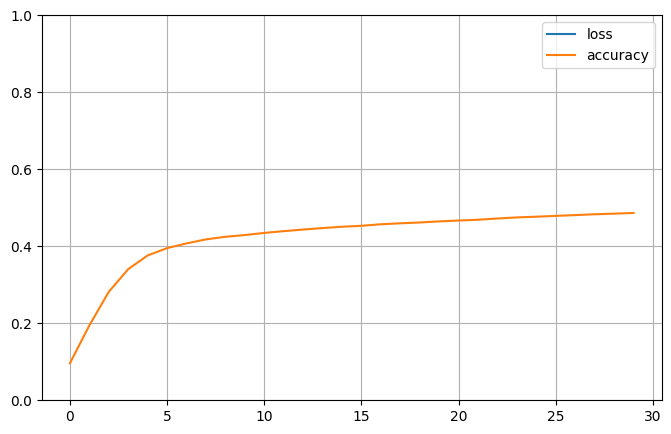

In [41]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [42]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

3125/3125 [==============================] - 12s 4ms/step - loss: 1.4553 - accuracy: 0.4868
test loss, test acc: [1.4552886486053467, 0.48684000968933105]


In [43]:
y_pred = np.argmax(model.predict(X), axis=-1)

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

3125/3125 [==============================] - 11s 4ms/step
[[3412  121  722  349  316  395  935 2349 1396    5]
 [  54 5077  937 1436  627  899  121   35  284  530]
 [ 706 1536 3390  947  719  683  591  350 1002   76]
 [ 111  997  393 6895  479  486  194   89  196  160]
 [ 390 1767 1124 1453 2302 1053  743  270  779  119]
 [ 187 1061  508  921  430 5517  373  176  502  325]
 [1013  396  790  799  827  901 2295 1626 1340   13]
 [ 785   37  165  128  113  222  964 6581 1005    0]
 [1011  462  926  467  545  717  875 1360 3613   24]
 [   3  134    4   45    3  156    3   28   22 9602]]
              precision    recall  f1-score   support

           0       0.44      0.34      0.39     10000
           1       0.44      0.51      0.47     10000
           2       0.38      0.34      0.36     10000
           3       0.51      0.69      0.59     10000
           4       0.36      0.23      0.28     10000
           5       0.50      0.55      0.52     10000
           6       0.32      0.2

Test Accuracy:0.48684


Text(0.5, 1.0, 'Accuracy:0.487')

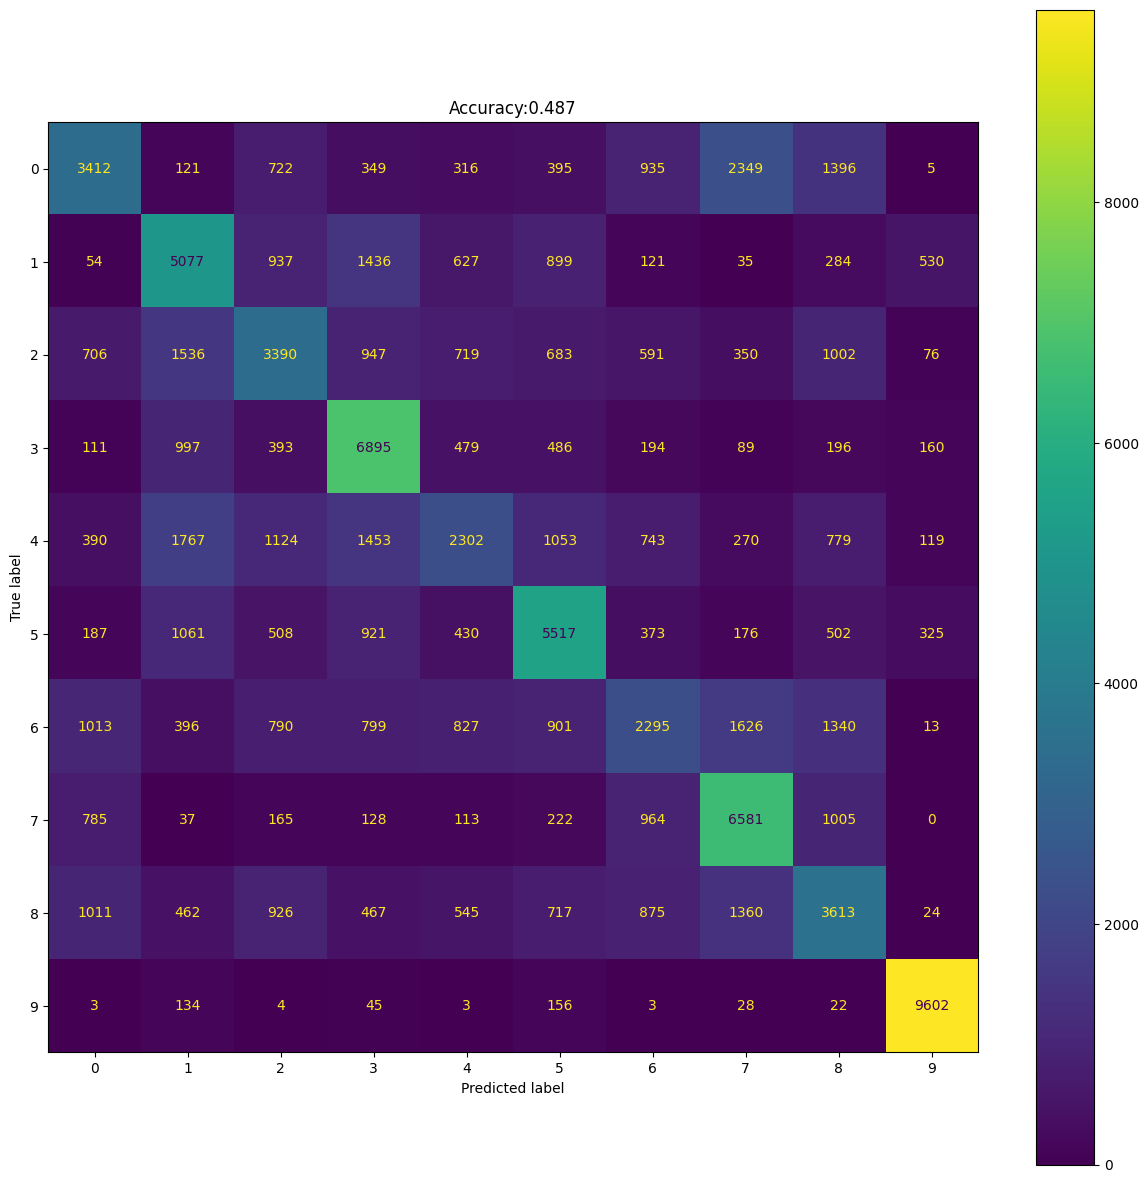

In [44]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone13/iPhone13_II_confusion_matrix.pdf')